In [20]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

In [9]:
BASE_DIR = os.path.join('data')
train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'val')
test_dir = os.path.join(BASE_DIR, 'test')

classes = os.listdir(train_dir)
print(classes)

['clock', 'telephone', 'chair']


In [4]:
train_ds = tf.data.Dataset.list_files(str(train_dir + '/*/*'))
test_ds = tf.data.Dataset.list_files(str(test_dir + '/*/*'))
val_ds = tf.data.Dataset.list_files(str(val_dir + '/*/*'))

2022-03-14 16:51:11.278613: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-14 16:51:11.278650: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-14 16:51:11.278672: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (IdeaPad): /proc/driver/nvidia/version does not exist
2022-03-14 16:51:11.281022: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
for path in train_ds.take(5):
    print(path)

tf.Tensor(b'data/train/clock/6INN0OWG3A31.jpg', shape=(), dtype=string)
tf.Tensor(b'data/train/telephone/8HMVNLNJCKQB.jpg', shape=(), dtype=string)
tf.Tensor(b'data/train/clock/4VCMM7Y254TO.jpg', shape=(), dtype=string)
tf.Tensor(b'data/train/clock/2YQCG94SALE5.jpg', shape=(), dtype=string)
tf.Tensor(b'data/train/chair/MCSGJYR1GAWN.jpg', shape=(), dtype=string)


In [13]:
@tf.function
def prepare_labeled_data(path):
    cat_labels = tf.strings.split(path, '/')[-2]
    one_hot_labels = tf.cast( cat_labels == classes, tf.int8)
    
    img = tf.image.decode_image(tf.io.read_file(path), expand_animations=False)
    
    return img, one_hot_labels

tf.Tensor([0 0 1], shape=(3,), dtype=int8) (128, 128, 3)


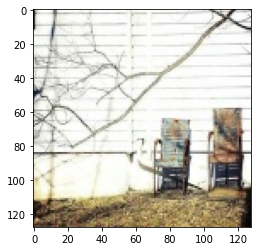

In [25]:
img, label = prepare_labeled_data('data/train/chair/MCSGJYR1GAWN.jpg')
print(label, img.shape)
plt.imshow(img)

In [27]:
CROP_SIZE = 128
RESIZE_TO = 135

In [49]:
@tf.function
def augmentation(img):
    img = tf.image.resize(img, (RESIZE_TO, RESIZE_TO))
    img = tf.image.random_crop(img, size=[CROP_SIZE, CROP_SIZE,3])
    img = tf.image.random_brightness(img, max_delta=.2)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img /= 255
    return img

In [50]:
@tf.function
def preprocess_train(path):
    img, label = prepare_labeled_data(path)
    img = augmentation(img)
    return img, label

In [51]:
@tf.function
def preprocess_test(path):
    img, label = prepare_labeled_data(path)
    img = tf.image.resize(img, (CROP_SIZE, CROP_SIZE))
    img = tf.image.convert_image_dtype(img, tf.float32)
    img /= 255
    return img, label

In [52]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
BUFFER_SIZE = 1000
REPEAT = 2

In [53]:
train_ds = train_ds.repeat(REPEAT).map(preprocess_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.map(preprocess_test).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.map(preprocess_test).batch(BATCH_SIZE).prefetch(AUTOTUNE)